In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [72]:
# Carga de los dataset
clientes = pd.read_csv ('olist_customers_dataset.csv')
ubicacion = pd.read_csv ('olist_geolocation_dataset.csv')
articulos_por_pedido = pd.read_csv ('olist_order_items_dataset.csv')
pagos = pd.read_csv('olist_order_payments_dataset.csv')
pedidos = pd.read_csv('olist_orders_dataset.csv')
calificaciones = pd.read_csv('olist_order_reviews_dataset.csv')
productos = pd.read_csv('olist_products_dataset.csv')
vendedores = pd.read_csv('olist_sellers_dataset.csv')
traduccion_categorias = pd.read_csv('product_category_name_translation.csv')

# Análisis exploratorio de datos

### Variable Target 
- Las calificaciones perfectas componen la mayoría de los datos
- El dataset se balaceará de mejor forma al combinar calificaciones imperfectas 1,2,3 y 4
    * 1 si el score del cliente es 5 
    * 0 si el score del cliente es diferente de 5


<AxesSubplot:title={'center':'Conteo de calificaciones'}, ylabel='review_score'>

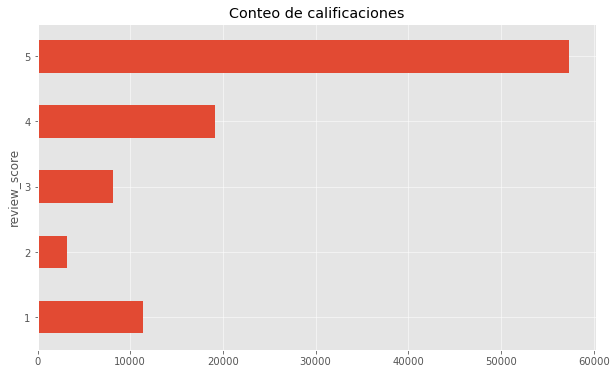

In [73]:
(calificaciones
    .groupby('review_score')
    .count()
    .review_id.plot
    .barh(figsize=(10,6), title= "Conteo de calificaciones"))

<AxesSubplot:title={'center':'Balance variable Target'}, ylabel='review_score'>

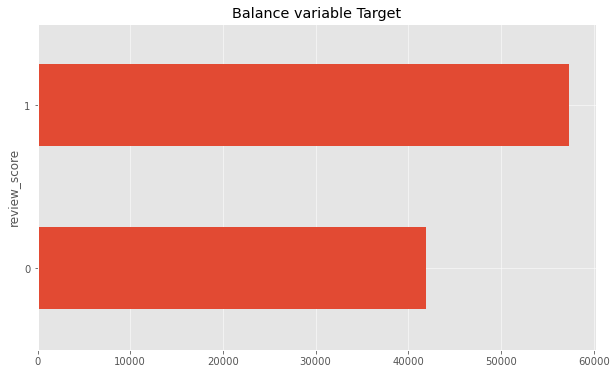

In [74]:
def balanceTarget(score):
    if score == 5:
        return 1
    else:
        return 0

calificaciones['score'] = calificaciones.review_score.apply(balanceTarget)
calificaciones = calificaciones.drop(columns='review_score')
calificaciones.rename(columns={"score": "review_score"},inplace=True)
calificaciones.groupby('review_score').count().review_id.plot.barh(figsize=(10,6), title= "Balance variable Target")

### Exploración de datos
- Nuestro dataset principal es el de calificaciones ya que contiene la variable target, la cantidad de registros es de 99 mil
- Se tienen 96 mil clientes y 98 mil calificaciones, lo que nos permite pensar que hay clientes que califican mas de una vez
- La cantidad de clientes supera en una proporción de 30 a uno la cantidad de vendedores
- Se ofrecen a través del E-Commerce cerca de 33 mil productos en 73 categorias

In [75]:
print('Tamaño del dataset clientes: '+str(clientes.shape))
print('Tamaño del dataset ubicacion: '+str(ubicacion.shape))
print('Tamaño del dataset articulos_por_pedido: '+str(articulos_por_pedido.shape))
print('Tamaño del dataset pagos: '+str(pagos.shape))
print('Tamaño del dataset pedidos: '+str(pedidos.shape))
print('Tamaño del dataset calificaciones:'+str(calificaciones.shape))
print('Tamaño del dataset productos: '+str(productos.shape))
print('Tamaño del dataset vendedores: '+str(vendedores.shape))
print('Tamaño del dataset traduccion_categorias: '+str(traduccion_categorias.shape))
print('=========================================================================')
print('Conteo único de clientes únicos: '+str(clientes.customer_unique_id.nunique()))
print('Conteo único de calificaciones: '+str(calificaciones.review_id.nunique()))
print('Conteo único de vendedores: '+str(vendedores.seller_id.nunique()))
print('Conteo único de productos: '+str(productos.product_id.nunique()))
print('Conteo único de categorias de los productos: '+str(productos.product_category_name.nunique()))


Tamaño del dataset clientes: (99441, 5)
Tamaño del dataset ubicacion: (1000163, 5)
Tamaño del dataset articulos_por_pedido: (112650, 7)
Tamaño del dataset pagos: (103886, 5)
Tamaño del dataset pedidos: (99441, 8)
Tamaño del dataset calificaciones:(99224, 7)
Tamaño del dataset productos: (32951, 9)
Tamaño del dataset vendedores: (3095, 4)
Tamaño del dataset traduccion_categorias: (71, 2)
Conteo único de clientes únicos: 96096
Conteo único de calificaciones: 98410
Conteo único de vendedores: 3095
Conteo único de productos: 32951
Conteo único de categorias de los productos: 73


### Período de recolección:
- Los datos fueron colectados entre 2016 y 2018, en la figura se observa que el volumen de compras aumenta en febrero de 2017 y cae abruptamente para octubre de 2018

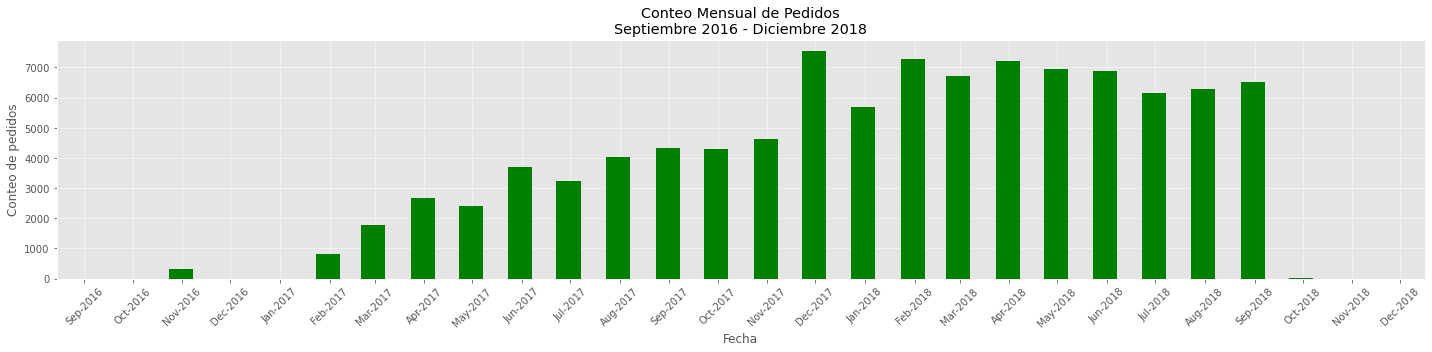

In [76]:
# Conversión a datetime en las fechas de pedidos
pedidos["order_purchase_timestamp"] = pd.to_datetime(pedidos["order_purchase_timestamp"])
pedidos["order_approved_at"] = pd.to_datetime(pedidos["order_approved_at"])
pedidos["order_delivered_carrier_date"] = pd.to_datetime(pedidos["order_delivered_carrier_date"])
pedidos["order_delivered_customer_date"] = pd.to_datetime(pedidos["order_delivered_customer_date"])
pedidos["order_estimated_delivery_date"] = pd.to_datetime(pedidos["order_estimated_delivery_date"])

# Agrupación por mes y configuración de la figura
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(pedidos.resample('M', on='order_purchase_timestamp').count()['order_id'].index,
       pedidos.resample('M', on='order_purchase_timestamp').count()['order_id'].values,
       color='green',
       width=15)

ax.set(xlabel="Fecha",
       ylabel="Conteo de pedidos",
       title="Conteo Mensual de Pedidos\nSeptiembre 2016 - Diciembre 2018")

date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.tick_params(axis='x', labelrotation = 45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
fig.tight_layout()
plt.show()

### Estatus de los pedidos: 
- Se observa en la tabla que la mayoria de pedidos estan concentrados en el estado delivered, esto quiere decir que dicha variable no tiene poder clasificatorio por lo que será eliminada

In [77]:
# Conteo de pedidos por estatus

# Resample de cada estatus por mes
delivered = pedidos.loc[pedidos.order_status == 'delivered'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('delivered')
invoiced = pedidos.loc[pedidos.order_status == 'invoiced'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('invoiced')
processing = pedidos.loc[pedidos.order_status == 'processing'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('processing')
shipped = pedidos.loc[pedidos.order_status == 'shipped'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('shipped')
unavailable = pedidos.loc[pedidos.order_status == 'unavailable'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('unavailable')
canceled = pedidos.loc[pedidos.order_status == 'canceled'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('canceled')
created = pedidos.loc[pedidos.order_status == 'created'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('created')
approved = pedidos.loc[pedidos.order_status == 'approved'].resample('M', on='order_purchase_timestamp').count()['order_id'].rename('approved')

# Creación de nuevo dataset para visualización
status=pd.concat([delivered, invoiced, shipped, processing, unavailable,canceled, created, approved],axis=1)
status.fillna(0,inplace=True)

# Conversión de datos y aplicación de gradiente a la tabla
status.astype('int64').style.background_gradient(cmap='Blues',axis=1)

,delivered,invoiced,shipped,processing,unavailable,canceled,created,approved
order_purchase_timestamp,,,,,,,,
2016-09-30 00:00:00,1,0,1,0,0,2,0,0
2016-10-31 00:00:00,265,18,8,2,7,24,0,0
2016-11-30 00:00:00,0,0,0,0,0,0,0,0
2016-12-31 00:00:00,1,0,0,0,0,0,0,0
2017-01-31 00:00:00,750,12,16,9,10,3,0,0
2017-02-28 00:00:00,1653,11,21,32,45,17,0,1
2017-03-31 00:00:00,2546,3,45,23,32,33,0,0
2017-04-30 00:00:00,2303,14,49,10,9,18,0,1
2017-05-31 00:00:00,3546,16,55,23,31,29,0,0


### Métodos de pago:
- El 73.92% de los clientes utlizan tarjetas de crédito para hacer las compras de sus pedidos, esto representa un ingreso de 12.5 Millones de reales brasileños
- El 50.58% de los clientes no difieren sus pagos en cuotas


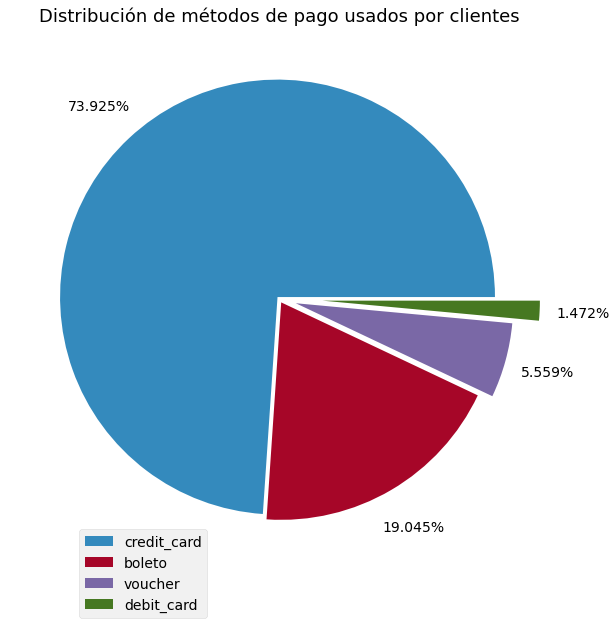

In [78]:
pType = pagos.payment_type.value_counts(normalize = True).mul(100)

plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Distribución de métodos de pago usados por clientes",fontsize=18)
ax.pie(
        pType.values[0:4],                      # Porcentajes de tipo de pago
        labels=pType.index[0:4],                # Indices como etiquetas
        explode=(0.01, 0.02, 0.08, 0.2),        # División de las zonas del pie
        autopct='%1.3f%%',                      # Resolución del valor flotante que representa el porcentaje
        pctdistance=1.2,                        # Distancia de la etiqueta a la zona del pie
        labeldistance=None,                     # Se oculta la etiqueta índice
        textprops={'fontsize': 14})             # Tamaño del numero que representa el porcentaje
        
ax.legend(loc='lower center', bbox_to_anchor=(0., -0.1, 0.5, 0.5), fontsize=14)

In [79]:
(pagos
    .groupby(by='payment_type')['payment_value']
    .sum()
    .sort_values(ascending=False)
    .apply(lambda x: "R${:.2f} M".format((x/1000000)))
    .to_frame()
)

,payment_value
payment_type,
credit_card,R$12.54 M
boleto,R$2.87 M
voucher,R$0.38 M
debit_card,R$0.22 M
not_defined,R$0.00 M


Porcentaje de clientes que no difieren sus pagos:50.58044394817396


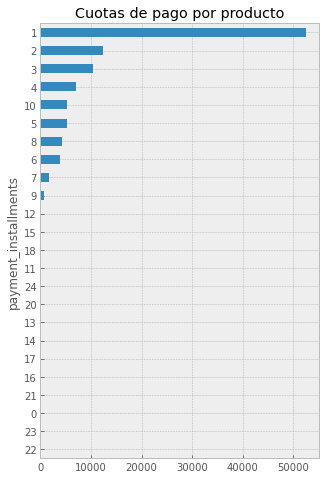

In [80]:
# Gráfico de barras para ver la cantidad de usuarios que difieren pagos
(pagos
    .groupby('payment_installments')
    .count().order_id
    .sort_values(ascending=True)
    .plot.barh(figsize=(5,8), title= "Cuotas de pago por producto")
)

# Cálculo del porcentaje
OneShoot = pagos.loc[pagos.payment_installments == 1, 'order_id'].count()
Total = pagos.order_id.count()
print("Porcentaje de clientes que no difieren sus pagos:"+ str(OneShoot/Total * 100))


### Categorias relevantes 
- Sólo 7 Categorias vendieron más de 1 Millón de Reales
- Las mismas 7 categorias vendieron mas de 6000 productos 

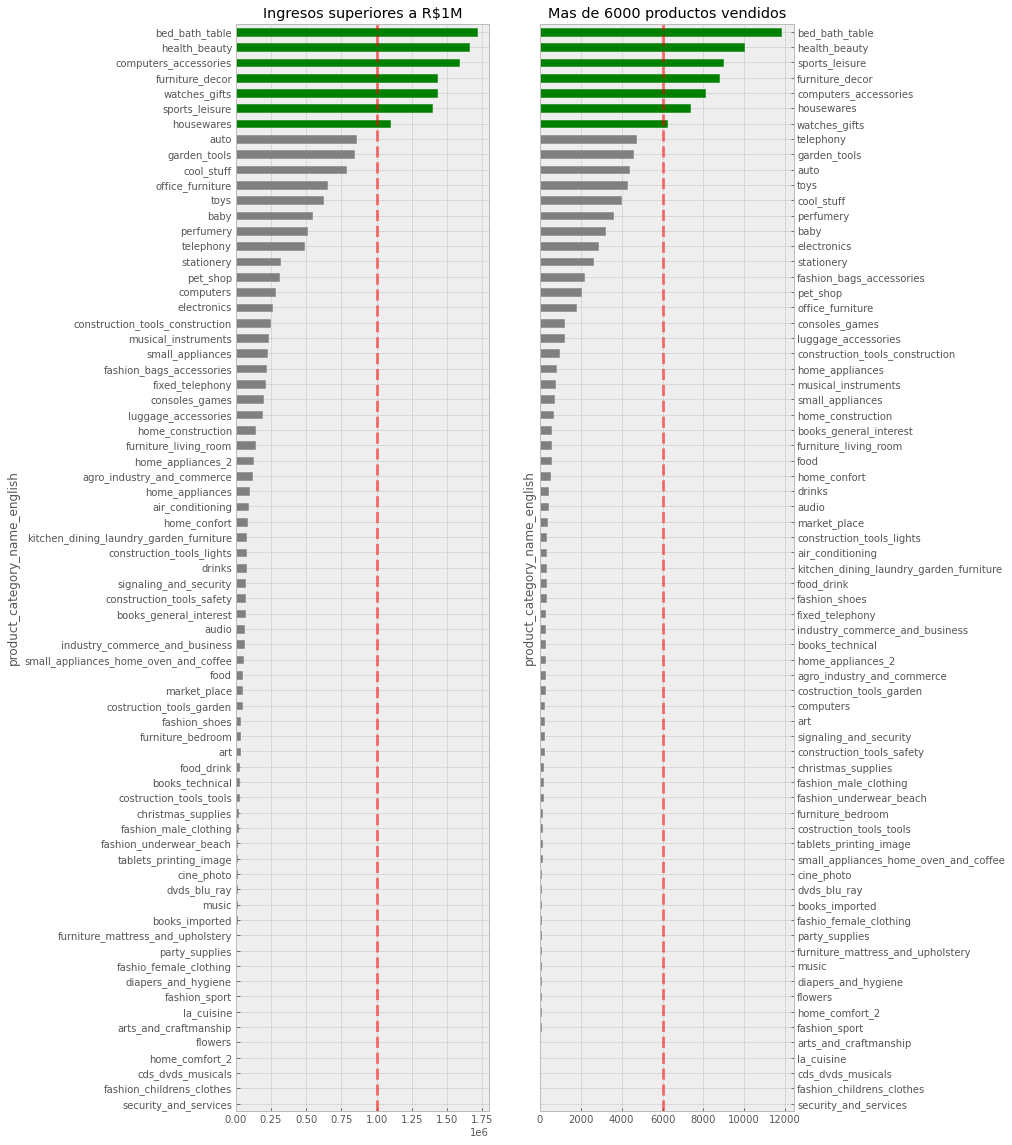

In [81]:
# Preparación de la figura
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(10, 20))

# Creación de dataframe para calular el ingreso por categoria
df1 = ( 
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                            articulos_por_pedido,pedidos, on ='order_id', validate= 'm:1'
                        ),pagos, on  ='order_id'
                    ),productos,on = 'product_id'
                ),traduccion_categorias, on='product_category_name', validate='m:1'
            )
        .groupby('product_category_name_english')['payment_value']
        .sum()
        .sort_values(ascending=True)
)

# Creación de dataframe para calular el volumen de compra
df2 = ( 
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                            articulos_por_pedido,pedidos, on ='order_id', validate= 'm:1'
                        ),pagos, on  ='order_id'
                    ),productos,on = 'product_id'
                ),traduccion_categorias, on='product_category_name', validate='m:1'
            )
        .groupby('product_category_name_english')
        .count()
        .order_id
        .sort_values(ascending=True)
    )

# Grafica de cada dataframes
df1.plot(kind='barh', ax=ax1, align='center')
df2.plot(kind='barh', ax=ax2, align='center')
ax2.yaxis.tick_right()

# Agregar lineas de referencia
ax1.axvline(1000000, color='red', linestyle='--', alpha=0.5, linewidth=3)
ax2.axvline(6000, color='red', linestyle='--', alpha=0.5, linewidth=3)

# Agregar titulos
ax1.set_title('Ingresos superiores a R$1M')
ax2.set_title('Mas de 6000 productos vendidos')

# Ajustar el color de las barras que se requieren resaltar
for bar in ax1.patches:
    if bar == ax1.patches[-1] or bar in ax1.patches[-7:-1]:
        bar.set_color('green') 
    else:
        bar.set_color('grey')

for bar in ax2.patches:
    if bar == ax2.patches[-1] or bar in ax2.patches[-7:-1]:
        bar.set_color('green') 
    else:
        bar.set_color('grey')

In [82]:
df1.sort_values(ascending=False)[:10]

product_category_name_english
bed_bath_table           1712553.67
health_beauty            1657373.12
computers_accessories    1585330.45
furniture_decor          1430176.39
watches_gifts            1429216.68
sports_leisure           1392127.56
housewares               1094758.13
auto                      852294.33
garden_tools              838280.75
cool_stuff                779698.00
Name: payment_value, dtype: float64

### Distrubución de precios 

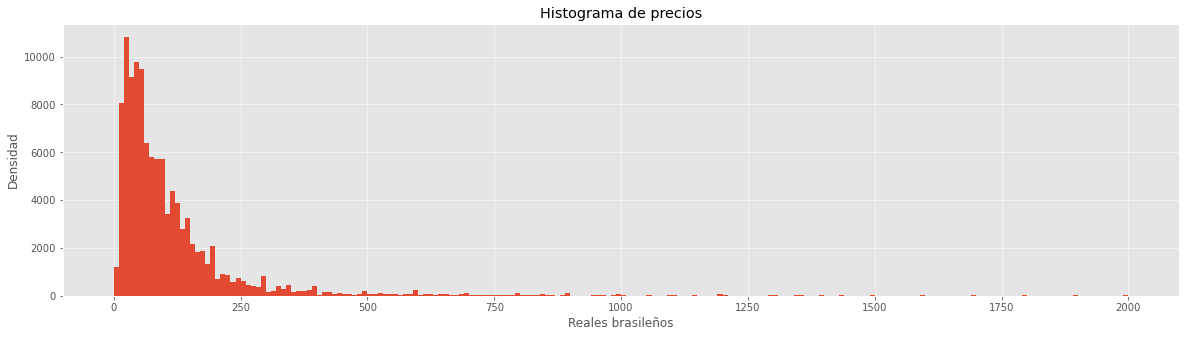

In [83]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 5))                
ax.set_title('Histograma de precios')                   
ax.set_xlabel('Reales brasileños')
ax.set_ylabel('Densidad')                             
figura = ax.hist(articulos_por_pedido.price, bins=200, range =(0,2000))          
plt.show(figura) 

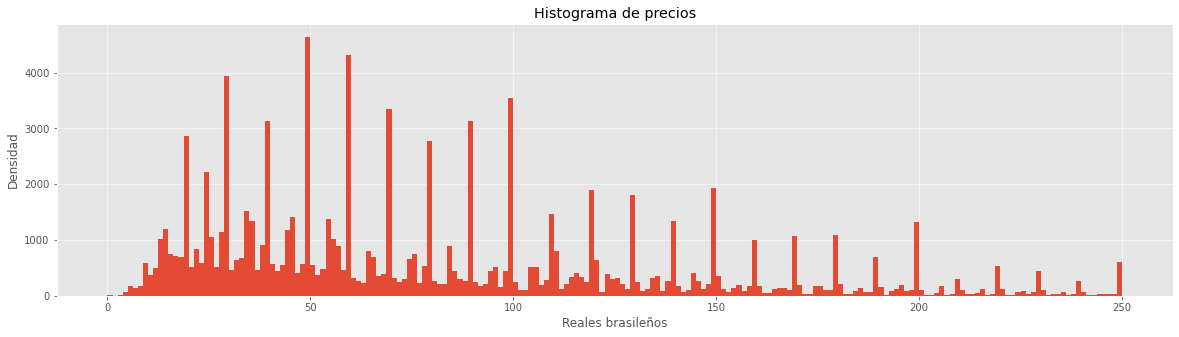

In [84]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 5))                
ax.set_title('Histograma de precios')                   
ax.set_xlabel('Reales brasileños')
ax.set_ylabel('Densidad')                             
figura = ax.hist(articulos_por_pedido.price, bins=200, range =(0,250))          
plt.show(figura)  

# Limpieza de datos
- Se hace un merge entre todos los csv originales para tener un dataset con todas las caracteristicas
- Se eliminan todos los id
- Se eliminan columnas que no se pueden usar como:
    * Algunos datos de ubicación
    * Nombre de la categoria en portugués
    * Comentarios y títulos
    * Algunas Fechas 

In [85]:
df = pedidos.merge(clientes, on="customer_id").merge(articulos_por_pedido, on="order_id").merge(productos, on="product_id").merge(traduccion_categorias, on="product_category_name").merge(pagos, on="order_id").merge(vendedores, on="seller_id").merge(calificaciones, on="order_id")
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'review_id', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'review_score'],
      dtype='object')

In [86]:
df = df.drop(columns=['order_id',
                      'customer_id',
                      'review_id',
                      'product_id',
                      'seller_id',
                      'order_item_id',
                      'review_comment_title',
                      'review_comment_message',
                      'review_answer_timestamp',
                      'customer_city',
                      'seller_city',
                      'payment_sequential',
                      ])
df.columns

Index(['order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_state', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_state',
       'review_creation_date', 'review_score'],
      dtype='object')

# Correlación de datos
- No se encuentran variables que puedan indicar una correlación relevante para el score dado por un cliente
- Algunas correlaciones son evidentes como:
    - El precio y el pago realizado por el cliente
    - El precio de envío y las dimensiones del producto
    - Descripción del producto y cantidad de fotos puestas por el vendedor

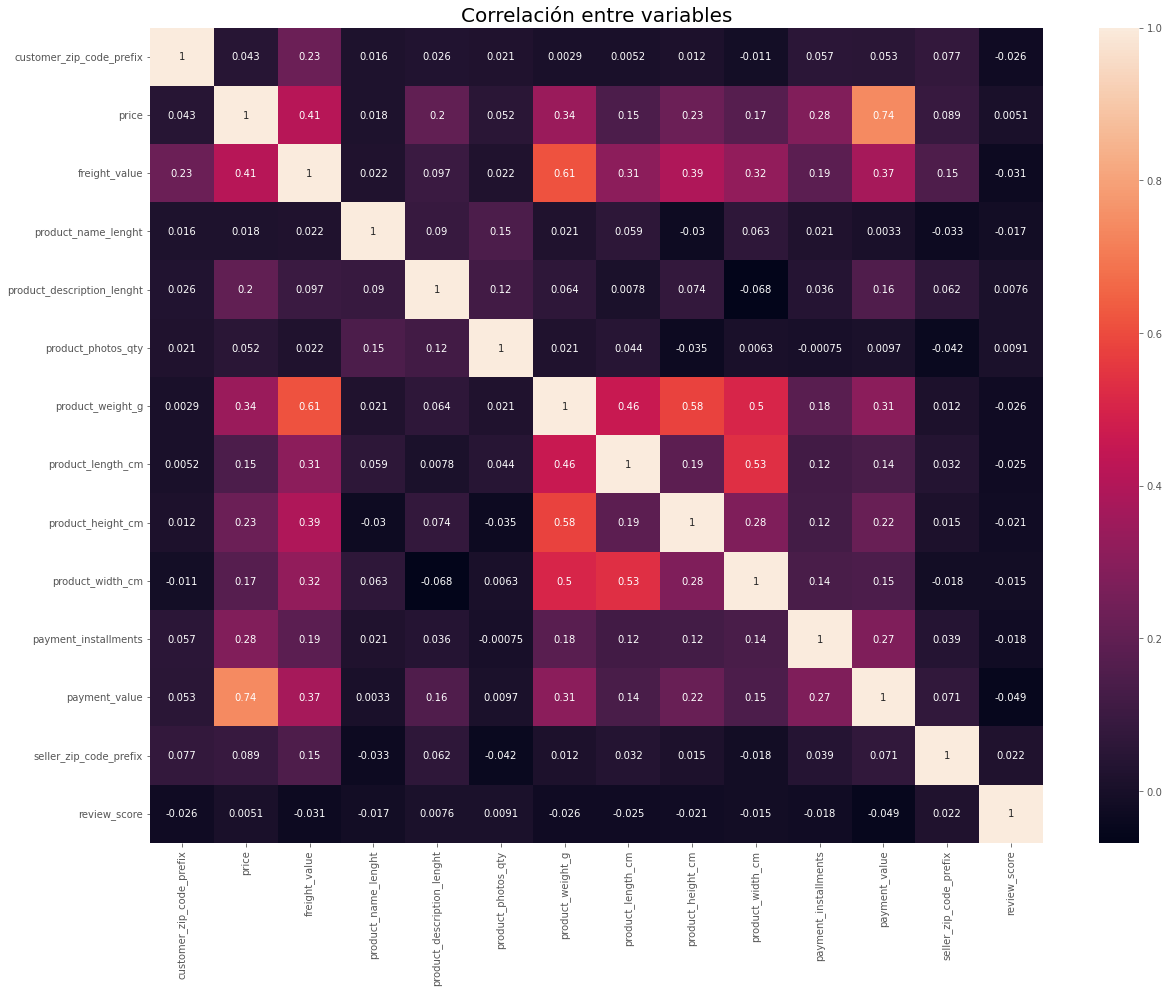

In [87]:
plt.rcParams['figure.figsize'] = (20, 15)

sns.heatmap(df.corr(), annot = True)
plt.title('Correlación entre variables', fontsize = 20)
plt.show()

# Ingenieria de datos (creación de variables)

- Conversion de fechas en días:
    * Dias entre la entrega y la fecha de compra
    * Días entre la promesa de entrega de Olist y la entrega real 
    * Dias entre la entrega al cliente y la calificación en la página
    * Días entre la entrega al cliente y el tiempo limite para la entrega del carrier
    * Dias entre la entrega al carrier por parte del vendedor y la fecha limite de despacho
    * Dias entre la compra del cliente y la aprobación del peido

In [88]:
# Conversión a datetime en las fechas 
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_approved_at"] = pd.to_datetime(df["order_approved_at"])
df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["shipping_limit_date"] = pd.to_datetime(df["shipping_limit_date"])
df["review_creation_date"] = pd.to_datetime(df["review_creation_date"])

In [89]:
# Dias entre la entrega y la fecha de compra
df['days_compra_entrega'] = (df.order_delivered_customer_date - df.order_purchase_timestamp).dt.days
# Días entre la promesa de entrega de Olist y la entrega real 
df['days_promesa_entrega'] = (df.order_estimated_delivery_date - df.order_delivered_customer_date).dt.days
# Dias entre la entrega al cliente y la calificación en la página
df['days_calificacion_entrega'] = (df.order_delivered_customer_date - df.review_creation_date).dt.days
# Días entre la entrega al cliente y el tiempo limite para la entrega del carrier
df['days_carrier_entrega'] = (df.order_delivered_customer_date - df.shipping_limit_date).dt.days
# Dias entre la entrega al carrier por parte del vendedor y la fecha limite de despacho
df['days_vendedor_carrier'] = (df.order_delivered_carrier_date - df.shipping_limit_date).dt.days
# Dias entre la compra del cliente y la aprobación del peido
df['days_vendedor_carrier'] = (df.order_purchase_timestamp - df.order_approved_at).dt.days

# Se limpia el dataset de las variables tipo fecha
df = df.drop(columns=["order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date","shipping_limit_date","review_creation_date"])

- Conversión de estados de Brasil en regiones
    * Se creó un archivo CSV con las regiones del país 
    * Se crean variables numericas equivalentes a las regiones del vendedor y el comprador

In [90]:
# Se carga un csv con las regiones de brasil
regiones = pd.read_csv('Regiones.csv')

# Se establece como indice el estado
regiones.set_index('REF',inplace=True)

# Se define una función para crear la nueva variable
def setRegion(R):
    return regiones.loc[R].Region_Nro

# Se aplica la función para la ubicación del vendedor y del comprador
df['Region_Vendedor'] = df.seller_state.apply(setRegion)
df['Region_Comprador'] = df.customer_state.apply(setRegion)

# Se eliminan las variables de ubicación originales
df = df.drop(columns=['customer_zip_code_prefix','customer_state','seller_zip_code_prefix','seller_state'])

- Conversión de categorias
    * Utilizando información del EDA se obtuvo que 7 productos superan el millón de reales en ventas
    * Se crea una variable que clasifica las categorias en 2 grupos, 1 para las que tiene mas ventas y 0 para las que no superan este valor

In [91]:
# Se define una función para crear la nueva variable
def topCategory(P):
    if P in ['bed_bath_table','health_beauty','computers_accessories','furniture_decor','watches_gifts','sports_leisure','housewares']:
        return 1
    else:
        return 0

# Se aplica la función para el top de categorias
df['topCategory'] = df.product_category_name_english.apply(topCategory)

# Se eliminan las variables originales
df = df.drop(columns=['product_category_name','product_category_name_english'])


- Precios de los productos

In [92]:
def rangoPrecios(monto):
    if monto < 50:
        return "menor_50"
    elif monto < 100:
        return "menor_100"
    elif monto < 150:
        return "menor_150"
    elif monto < 200:
        return "menor_200"
    elif monto >= 200:
        return "mayor_200"

df['RangoPrecios'] = df.price.apply(rangoPrecios)

In [93]:
df = df.drop(columns=['price',
                      'freight_value',
                      'product_name_lenght',
                      'product_description_lenght',
                      'product_photos_qty',
                      'product_weight_g',
                      'product_length_cm',
                      'product_height_cm',
                      'product_width_cm',
                      'payment_installments',
                      'payment_value'])

In [94]:
df.columns

Index(['order_status', 'customer_unique_id', 'payment_type', 'review_score',
       'days_compra_entrega', 'days_promesa_entrega',
       'days_calificacion_entrega', 'days_carrier_entrega',
       'days_vendedor_carrier', 'Region_Vendedor', 'Region_Comprador',
       'topCategory', 'RangoPrecios'],
      dtype='object')

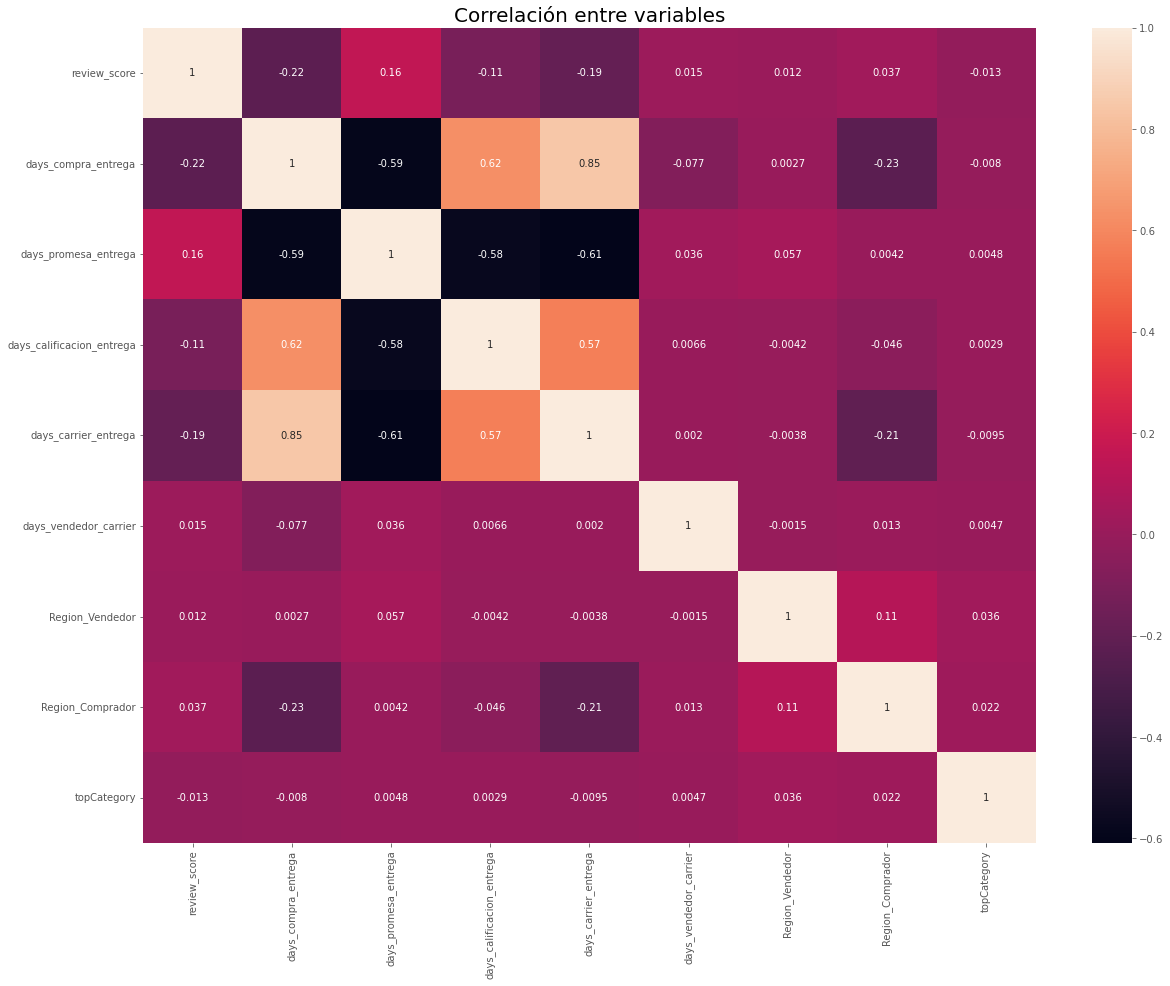

In [95]:
plt.rcParams['figure.figsize'] = (20, 15)

sns.heatmap(df.corr(), annot = True)
plt.title('Correlación entre variables', fontsize = 20)
plt.show()

# KMEANS

- Se busca crear agrupar los clientes segun su comportamiento de compras
- La llave para identificar cada cliente será customer_unique_id
- Se utiliza la teoría de marketing RFM (Recency, Frecuency, Monetary Value)

¿Qué es un análisis RFM?
- En analitica de negocios se usa este concepto para segmentar los clientes en grupos de diferente valor para la compañia
    * Recency: ¿Qué tan recientemente hizo el cliente su última transacción?
    * Frequency: ¿Con qué frecuencia el cliente compra en el portal?
    * Monetary: ¿De cuánto es el ingreso que representa un cliente?

In [96]:
# Se crea un dataset para este analisi partiendo de los datos originales
df_kmeans = pedidos.merge(clientes, on="customer_id").merge(articulos_por_pedido, on="order_id").merge(productos, on="product_id").merge(traduccion_categorias, on="product_category_name").merge(pagos, on="order_id").merge(vendedores, on="seller_id").merge(calificaciones, on="order_id")

### Cálculo de la variable "Recency"

In [97]:
# Se crea un dataframe agrupado por clientes y obteniendo la última fecha de compra
df_recency = df_kmeans.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()

# Se renombra la columna solo para facilidad de la lectura de la tabla
df_recency.rename(columns={"order_purchase_timestamp":"LastPurchaseDate"}, inplace=True)

# Se convierte la fecha en una variable tipo date
df_recency ['LastPurchaseDate'] = pd.to_datetime(df_recency ['LastPurchaseDate'])

# Se obtene la fecha mas reciente de todas las compras de todos los clientes para tener una referencia
recent_date = pd.to_datetime(df_recency['LastPurchaseDate'].dt.date.max())

# Se crea la columna "Recency" que es la resta en dias de la fecha de la última compra de cada cliente y la referencia anterior
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

df_recency.head()

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


### Cálculo de la variable "Frecuency"

In [98]:
# Se crea un dataframe agrupando los cliente por los números únicos de orden
frequency_df = df_kmeans.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()

# Se renombra la columna solo para facilidad de la lectura de la tabla
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


### Cálculo de la variable "Monterary Value" 

In [99]:
# Se crea un nuevo dataframe agrupando los clientes por la sumatoria de todos sus pagos
monetary_df = df_kmeans.groupby('customer_unique_id', as_index=False)['payment_value'].sum()

# Se renombra la columna solo para facilidad de la lectura de la tabla
monetary_df.columns = ['customer_unique_id', 'Monetary']

monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


### Dataframe de entrenamiento para el algoritmo de clustering 

In [100]:
# Se hace un merge entre los dataframes creados para el analisis RFM
rf_df = df_recency.merge(frequency_df, on='customer_unique_id')
rfm_df = rf_df.merge(monetary_df, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19
2,0000f46a3911fa3c0805444483337064,541,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.89


Text(0.5, 0.98, 'Histogramas de RFM')

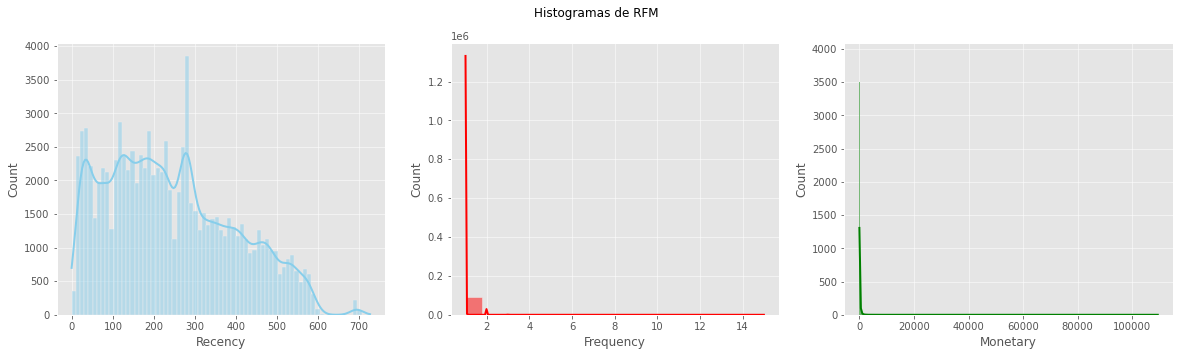

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data=rfm_df, x="Recency", kde=True, color="skyblue", ax=ax1)
sns.histplot(data=rfm_df, x="Frequency", kde=True, color="red", ax=ax2)
sns.histplot(data=rfm_df, x="Monetary", kde=True, color="green", ax=ax3)

fig.suptitle("Histogramas de RFM")

- Se observa que las variables de Frecuencia y valor monterio tienen un sesgo demasiado alto
- K-Means es muy sensible a valores atipicos
- Se ajustaran los datos sesgados de "Frecuency" y "Monetary" a una escala logaritmica

In [102]:
rfm_df[rfm_df.columns[1:]] = rfm_df[rfm_df.columns[1:]].applymap(lambda x: 1 if x == 0 else x)

rfm_df_log = rfm_df.copy()
for c in rfm_df.columns[2:]:
    rfm_df_log[c] = np.log10(rfm_df_log[c])

Text(0.5, 0.98, 'Histogramas de RFM (Luego de ajuste)')

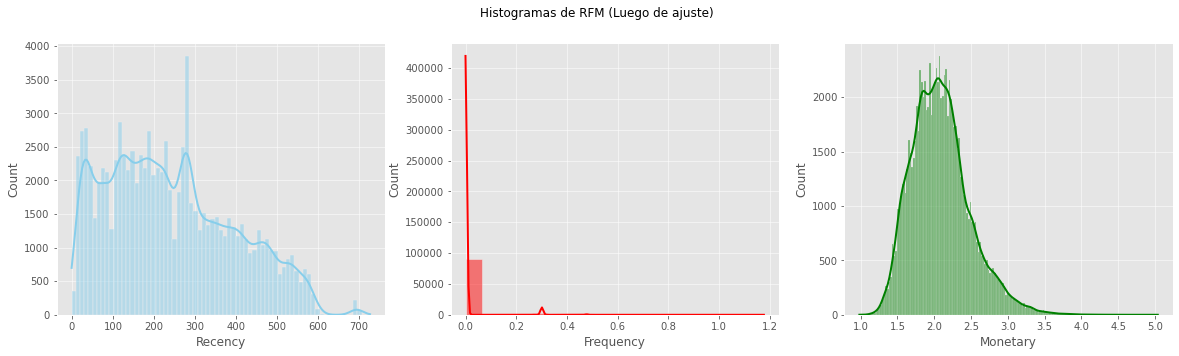

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data=rfm_df_log, x="Recency", kde=True, color="skyblue", ax=ax1)
sns.histplot(data=rfm_df_log, x="Frequency", kde=True, color="red", ax=ax2)
sns.histplot(data=rfm_df_log, x="Monetary", kde=True, color="green", ax=ax3)

fig.suptitle("Histogramas de RFM (Luego de ajuste)")

In [104]:
# Escalación estadística z = (x - u) / s
scaler = StandardScaler()
scaler.fit(rfm_df_log.drop("customer_unique_id", axis=1))
rfm_df_scaled = scaler.transform(rfm_df_log.drop("customer_unique_id", axis=1))

# Nuevo dataframe con los datos escalados
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=rfm_df_log.columns[1:])

### Entrenamiento del algoritmo

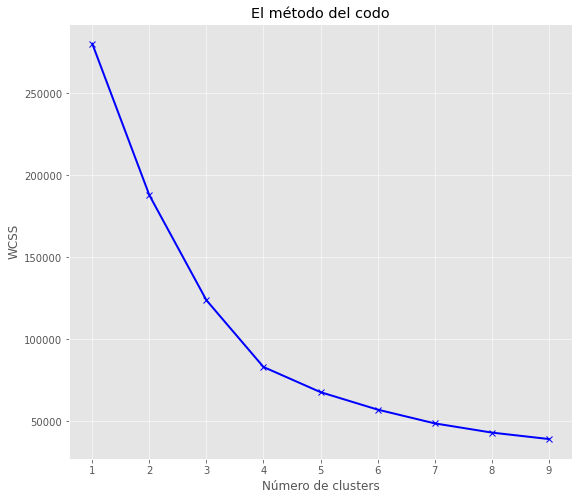

In [105]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)

# Grafica de la suma de las distancias
plt.figure(figsize=(9,8))
plt.plot(range(1, 10), wcss, 'bx-')
plt.title('El método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

- Se observa que el codo está entre 4 y 5 clusters
- La suma de las distancias se atenua a mayor numero de clusters
- Se tomará k = 5 para entrenar el modelo
- La frecuencia tiene un peso menor debido a que el mayor volumen de clientes solo hacen una compra

In [106]:
# Se crea el k-Means para los 5 grupos encontrados
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42) #k-means++ acelera la convergencia, respecto de random
y_kmeans = kmeans.fit_predict(rfm_df_scaled)

In [107]:
# Se agregan las etiquetas de los clúster al dataframe de rfm
rfm_df['Cluster'] = kmeans.labels_

# Se crea una función para visualzar los datos agrupados por el promedio
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

    return df_new

rfm_values(rfm_df)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         166.0       1.0     55.0  25393
1         225.0       2.0    488.0   2807
2         427.0       1.0    114.0  25626
3         266.0       1.0    814.0  11496
4         133.0       1.0    174.0  28074

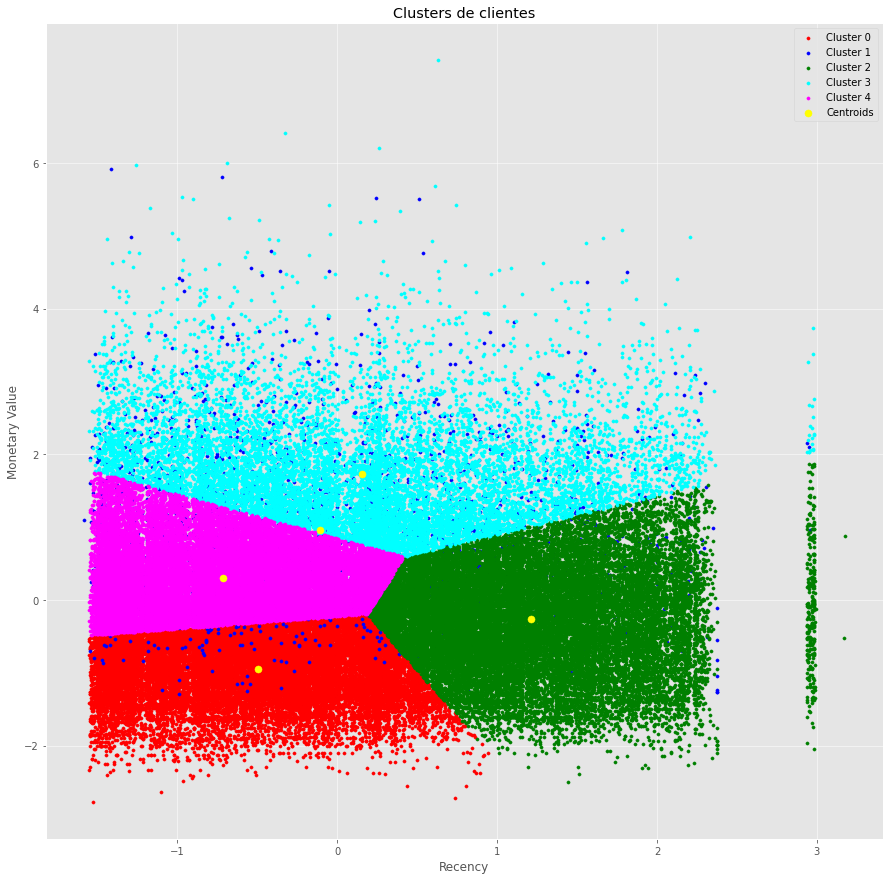

In [108]:
# Para hacer una visualización 2D se seleccionan las dimensiones de "Recency" y "Monetary"
X = rfm_df_scaled.iloc[:, [0, 2]].values

# Tamaño de la figura
plt.figure(figsize=(15,15))
# Clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Cluster 0')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 10, c = 'green', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 10, c = 'cyan', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 10, c = 'magenta', label = 'Cluster 4')
# Centroides
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s = 50, c = 'yellow', label = 'Centroids')

# Visualización
plt.title('Clusters de clientes')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()

## Resultados de K-Means
- se tienen 5 grupo de clientes:
    * Cluster 0: Clientes que compraron recientemente y gastaron poco
    * Cluster 1: Clientes más leales, con más compras de valor moderado
    * Cluster 2: Clientes que compraron alguna vez pero que no repitieron la compra
    * Cluster 3: Clientes valiosos que realizan compras de mayor valor
    * Cluster 4: Clientes potenciales, que compraron recientemente con un valor más alto en sus compras

# Algoritmos de clasificación
- Se tienen dos dataset:
    * El resultado de la ingenieria de datos resultante del EDA
    * El resultado del analisis con KMeans
- Se realizá un merge entre ambos datadrame a través del id del usuario
- Se aplicará un get dummies para las variables categóricas
- El dataframe resultante será usado en los algoritmos de clasificación

### Preparación del dataset

In [109]:
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,0
2,0000f46a3911fa3c0805444483337064,541,1,86.22,2
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,4


In [110]:
df.head()

,order_status,customer_unique_id,payment_type,review_score,days_compra_entrega,days_promesa_entrega,days_calificacion_entrega,days_carrier_entrega,days_vendedor_carrier,Region_Vendedor,Region_Comprador,topCategory,RangoPrecios
0,delivered,7c396fd4830fd04220f754e42b4e5bff,credit_card,0,8.0,7.0,-1.0,4.0,-1.0,4,4,1,menor_50
1,delivered,7c396fd4830fd04220f754e42b4e5bff,voucher,0,8.0,7.0,-1.0,4.0,-1.0,4,4,1,menor_50
2,delivered,7c396fd4830fd04220f754e42b4e5bff,voucher,0,8.0,7.0,-1.0,4.0,-1.0,4,4,1,menor_50
3,delivered,3a51803cc0d012c3b5dc8b7528cb05f7,credit_card,0,2.0,9.0,-1.0,-4.0,-1.0,4,4,1,menor_50
4,delivered,ef0996a1a279c26e7ecbd737be23d235,credit_card,1,5.0,7.0,-1.0,-2.0,-1.0,4,4,1,menor_50


In [111]:
df = rfm_df.merge(df, on='customer_unique_id').drop(columns=['Recency','Frequency','Monetary','customer_unique_id'])
df_ML = pd.get_dummies(df)

In [112]:
df_ML = pd.get_dummies(df)

In [113]:
df_ML.columns

Index(['Cluster', 'review_score', 'days_compra_entrega',
       'days_promesa_entrega', 'days_calificacion_entrega',
       'days_carrier_entrega', 'days_vendedor_carrier', 'Region_Vendedor',
       'Region_Comprador', 'topCategory', 'order_status_approved',
       'order_status_canceled', 'order_status_delivered',
       'order_status_invoiced', 'order_status_processing',
       'order_status_shipped', 'order_status_unavailable',
       'payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher',
       'RangoPrecios_mayor_200', 'RangoPrecios_menor_100',
       'RangoPrecios_menor_150', 'RangoPrecios_menor_200',
       'RangoPrecios_menor_50'],
      dtype='object')

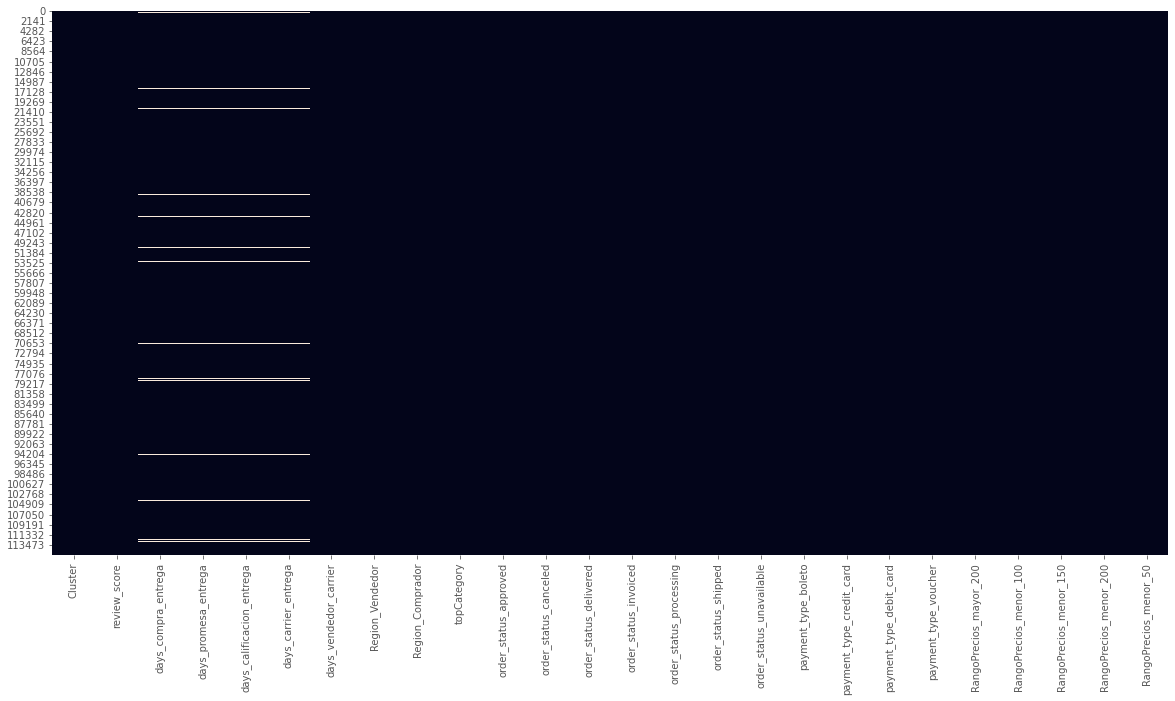

In [114]:
fig, ax = plt.subplots(figsize=(20,10))   
ax = sns.heatmap(df_ML.isnull(), cbar=False)

In [115]:
# Se eliminan los valores nulos
df_ML.dropna(inplace=True)

# DECISION TREE

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb

In [117]:
# Se separa en X e y
X = df_ML.drop("review_score", axis=1)     # Elimino de mi dataset la variable a predecir
y = df_ML.review_score                     # Defino el Target

# Separación del 70% de las muestras para entrenamiento
(X_train_m1, X_test_m1,
y_train_m1, y_test_m1) = train_test_split(X,
                                    y,
                                    stratify=y,
                                    test_size=0.30,
                                    random_state=30)

In [118]:
# Creamos un arbol de decisión sencillo y lo entrenamos
model_1 = DecisionTreeClassifier(max_depth=7, random_state = 42)
model_1.fit(X_train_m1, y_train_m1)

# Prueba de predicción
y_test_pred_m1 = model_1.predict(X_test_m1) 

In [119]:
# Accuracy
accuracy_m1 = accuracy_score(y_test_m1, y_test_pred_m1)
print(f"Accuracy: {accuracy_m1}")

# Recall
recall_m1 = recall_score(y_test_m1, y_test_pred_m1)
print(f"Recall Score: {recall_m1}")

# Precision
precision_m1 = precision_score(y_test_m1, y_test_pred_m1)
print(f"Precision Score: {precision_m1}")

# Calculo del F1 score
f1_m1 = f1_score(y_test_m1, y_test_pred_m1)
print(f"F1 Score: {f1_m1}")

Accuracy: 0.6374451544509555
Recall Score: 0.8786839950880065
Precision Score: 0.6333628383860737
F1 Score: 0.7361224227356509


c:\pythonMiniconda\envs\ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


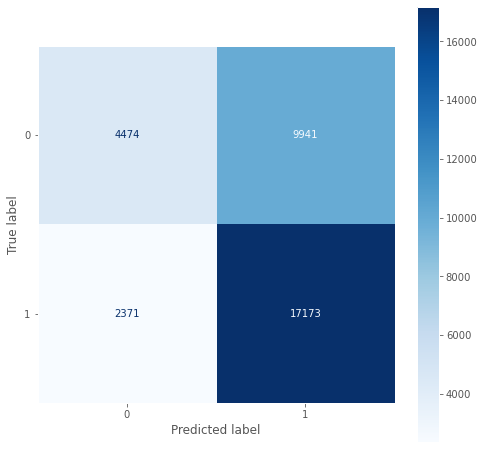

In [120]:
# Matriz de confusión
fig, ax = plt.subplots(figsize = (8, 8))
ax.grid(False)
confusion_matrix(y_test_m1,y_test_pred_m1)
plot_confusion_matrix(model_1, X_test_m1, y_test_m1, ax=ax, cmap='Blues')


c:\pythonMiniconda\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


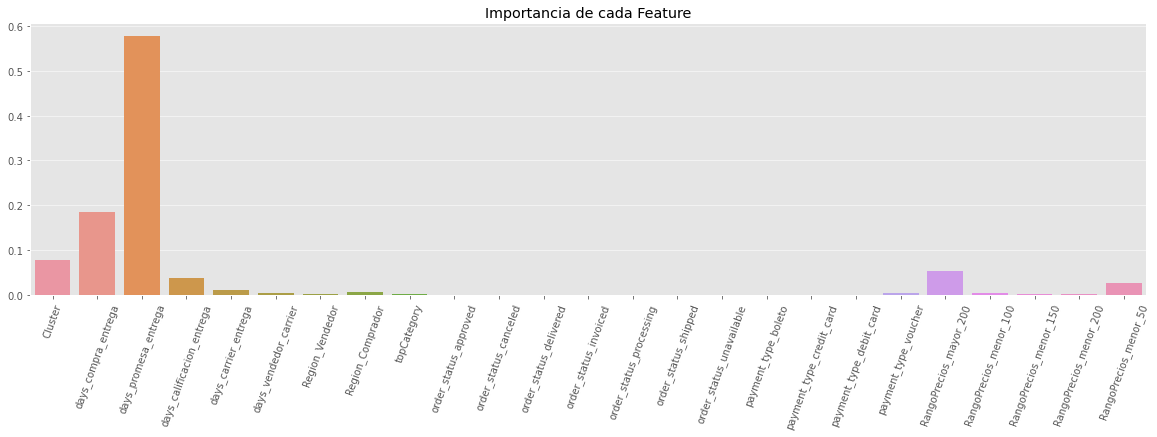

In [121]:
# Variables influyentes
plt.figure(figsize=(20,5))
importances = model_1.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.xticks(rotation=70)
plt.show()

# RANDOM FOREST

In [122]:
# Separamos en train y test!
(X_train_m2, X_test_m2,
y_train_m2, y_test_m2) = train_test_split(X,
                                    y,
                                    stratify=y,
                                    test_size=0.30,
                                    random_state=11)

In [123]:
# Creamos un random forest y lo entrenamos
model_2 = RandomForestClassifier(random_state=11, n_estimators=200,
                               class_weight="balanced", max_features="log2")
model_2.fit(X_train_m2, y_train_m2)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=200, random_state=11)

In [124]:
# Prueba de predicción
y_test_pred_m2 = model_2.predict(X_test_m2)

In [125]:
# Accuracy
accuracy_m2 = accuracy_score(y_test_m2, y_test_pred_m2)
print(f"Accuracy: {accuracy_m2}")

# Recall
recall_m2 = recall_score(y_test_m2, y_test_pred_m2)
print(f"Recall Score: {recall_m2}")

# Precision
precision_m2 = precision_score(y_test_m2, y_test_pred_m2)
print(f"Precision Score: {precision_m2}")

# Calculo del F1 score
f1_m2 = f1_score(y_test_m2, y_test_pred_m2)
print(f"F1 Score: {f1_m2}")

Accuracy: 0.6534644718631291
Recall Score: 0.752762996316005
Precision Score: 0.6796008869179601
F1 Score: 0.714313458924063


c:\pythonMiniconda\envs\ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


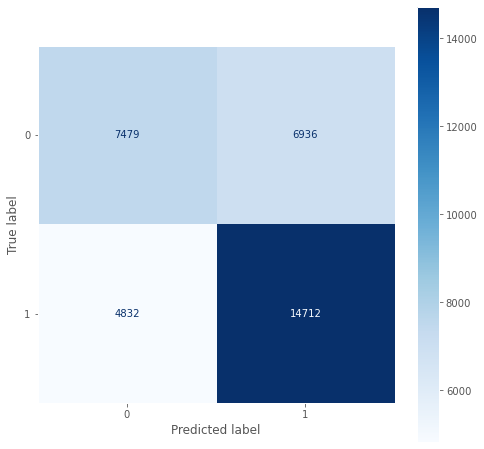

In [126]:
# Matriz de confusión
fig, ax = plt.subplots(figsize = (8, 8))    
ax.grid(False)
confusion_matrix(y_test_m2,y_test_pred_m2)
plot_confusion_matrix(model_2, X_test_m2, y_test_m2, ax=ax,cmap='Blues')

c:\pythonMiniconda\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


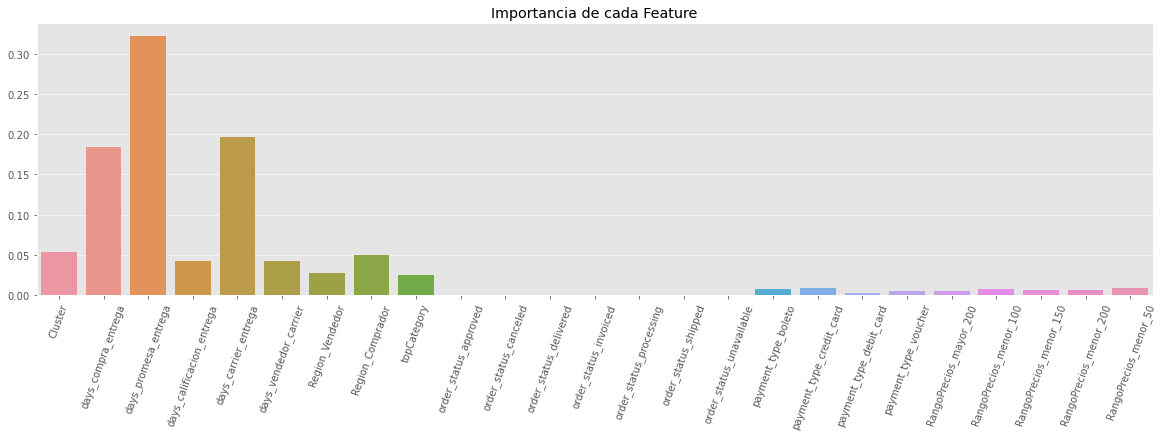

In [127]:
# Variables influyentes
plt.figure(figsize=(20,5))
importances = model_2.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.xticks(rotation=70)
plt.show()

# XGboost

In [128]:
# Separamos en train y test!
(X_train_m3, X_test_m3,
y_train_m3, y_test_m3) = train_test_split(X,
                                    y,
                                    stratify=y,
                                    test_size=0.30,
                                    random_state=11)

In [129]:
model_3 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10,seed=123)

model_3.fit(X_train_m3,y_train_m3) #Entrenamos el modelo

y_train_pred_m3 = model_3.predict(X_train_m3) #Prediccion en Train
y_test_pred_m3 = model_3.predict(X_test_m3) #Prediccion en Test

c:\pythonMiniconda\envs\ds\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\pythonMiniconda\envs\ds\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:45:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [130]:
# Accuracy
accuracy_m3 = accuracy_score(y_test_m3, y_test_pred_m3)
print(f"Accuracy: {accuracy_m3}")

# Recall
recall_m3 = recall_score(y_test_m3, y_test_pred_m3)
print(f"Recall Score: {recall_m3}")

# Precision
precision_m3 = precision_score(y_test_m3, y_test_pred_m3)
print(f"Precision Score: {precision_m3}")

# Calculo del F1 score
f1_m3 = f1_score(y_test_m3, y_test_pred_m3)
print(f"F1 Score: {f1_m3}")

Accuracy: 0.6381518890426691
Recall Score: 0.8841588211215718
Precision Score: 0.6328743041312628
F1 Score: 0.7377049180327869


c:\pythonMiniconda\envs\ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


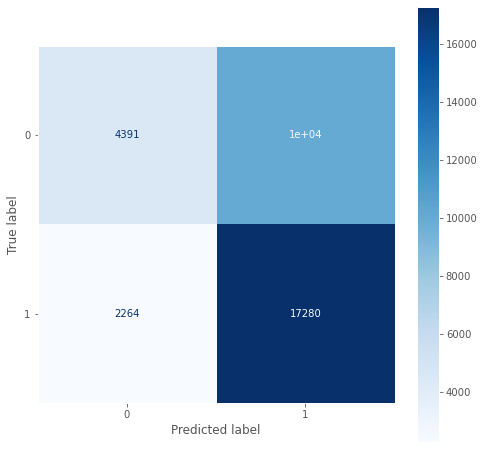

In [131]:
# Matriz de confusión
fig, ax = plt.subplots(figsize = (8, 8))    
ax.grid(False)
confusion_matrix(y_test_m3,y_test_pred_m3)
plot_confusion_matrix(model_3, X_test_m3, y_test_m3, ax=ax, cmap='Blues')

c:\pythonMiniconda\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


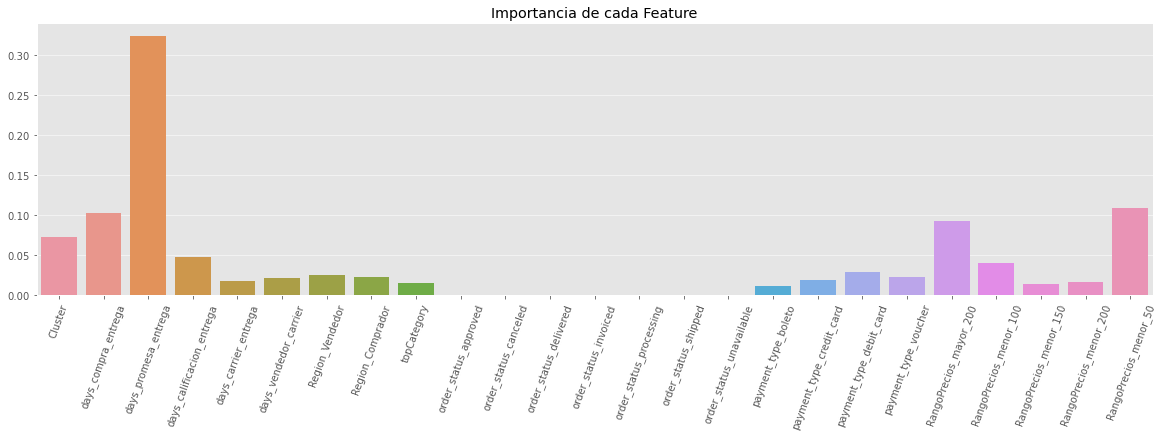

In [132]:
# Variables influyentes
plt.figure(figsize=(20,5))
importances = model_3.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.xticks(rotation=70)
plt.show()

# COMPARACIÓN DE MODELOS

In [133]:
data1 = {'accuracy_score':accuracy_m1,'precision':precision_m1,'recall':recall_m1,'f1':f1_m1}
data2 = {'accuracy_score':accuracy_m2,'precision':precision_m2,'recall':recall_m2,'f1':f1_m2}
data3 = {'accuracy_score':accuracy_m3,'precision':precision_m3,'recall':recall_m3,'f1':f1_m3}

df_res1 = pd.DataFrame.from_dict(data1, orient='index').rename(columns={0:'DecisionTree'})
df_res2 = pd.DataFrame.from_dict(data2, orient='index').rename(columns={0:'RandomForest'})
df_res3 = pd.DataFrame.from_dict(data3, orient='index').rename(columns={0:'XGBoost'})

df_res = pd.concat([df_res1,df_res2,df_res3],axis=1)

In [134]:
df_res.style.background_gradient(cmap='Blues',axis=1)

,DecisionTree,RandomForest,XGBoost
accuracy_score,0.637445,0.653464,0.638152
precision,0.633363,0.679601,0.632874
recall,0.878684,0.752763,0.884159
f1,0.736122,0.714313,0.737705


C:\Users\Wilmer Sanchez\AppData\Local\Temp\ipykernel_25304\2204411340.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr_m1, tpr_m1, 'b', label = 'Modelo 1 - Decision Tree - AUC = %0.2f' % roc_auc_m1, color = 'blue')
C:\Users\Wilmer Sanchez\AppData\Local\Temp\ipykernel_25304\2204411340.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr_m2, tpr_m2, 'b', label = 'Modelo 2 - Random Forest - AUC = %0.2f' % roc_auc_m2, color = 'red')
C:\Users\Wilmer Sanchez\AppData\Local\Temp\ipykernel_25304\2204411340.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr_m3, tpr_m3, 'b', lab

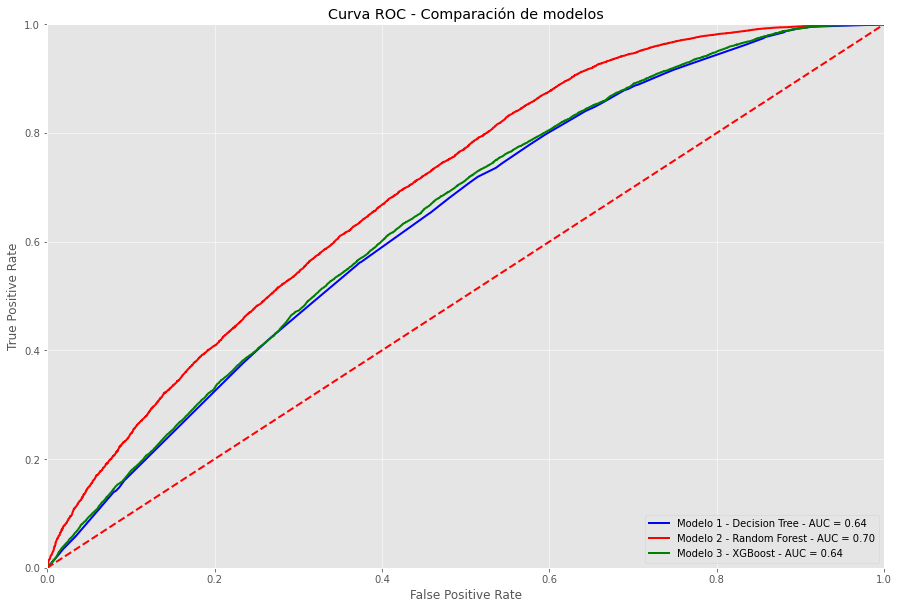

In [135]:
#Template CURVA - ROC

preds_m1 = model_1.predict_proba(X_test_m1)[:, 1]
preds_m2 = model_2.predict_proba(X_test_m2)[:, 1]
preds_m3 = model_3.predict_proba(X_test_m3)[:, 1]

fpr_m1, tpr_m1, threshold = roc_curve(y_test_m1, preds_m1)
roc_auc_m1 = auc(fpr_m1, tpr_m1)
fpr_m2, tpr_m2, threshold = roc_curve(y_test_m2, preds_m2)
roc_auc_m2 = auc(fpr_m2, tpr_m2)
fpr_m3, tpr_m3, threshold = roc_curve(y_test_m3, preds_m3)
roc_auc_m3 = auc(fpr_m3, tpr_m3)

# Gráfica de la Curva ROC
plt.figure(figsize=(15,10))
plt.title('Curva ROC - Comparación de modelos')
plt.plot(fpr_m1, tpr_m1, 'b', label = 'Modelo 1 - Decision Tree - AUC = %0.2f' % roc_auc_m1, color = 'blue')
plt.plot(fpr_m2, tpr_m2, 'b', label = 'Modelo 2 - Random Forest - AUC = %0.2f' % roc_auc_m2, color = 'red')
plt.plot(fpr_m3, tpr_m3, 'b', label = 'Modelo 3 - XGBoost - AUC = %0.2f' % roc_auc_m3, color = 'green' )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()